# Gaussian Processes Inferencing in Stingray

## Gaussian Processes in Astronomy

Gaussian Processes (GPs) are a powerful class of Statistical Models, that help us model both the deterministic and stochastic part of a random process. We model the covaraince between pairs of samples (using the kernel function) and the underlying deterministic function (using the mean function) and fit or infer from the data set. 

GP Regression and inferencing (GPR) has become increasingly popular in the astronomical community over the last decade as it can model non-trivial random or unkown signals. Sometimes, we are interested in the stochastic behaviour itself, and we can
infer its characteristics or predict its behaviour using Gaussian Processes.


While we can use GP's to produce models for various signals, we often have to identify if the particular time-series has a particular signal and we resort to Bayesian Model Comparison. We compare the two models by the Bayes factor, which is the ratio of the evidences of two comparing models. Since Evidence Calculation is a difficult problem, we will use Nested Sampling, with the Jaxns library to get the Bayes Factor.

## Sample Lightcurve
As an example demonstrating the use of gpmodeling in Stingray, we will make a sample lightcurve based on a QPO (quasi periodic signal), and use the ratio of Evidence of the following two models to identify whether the signal contains a Quasi-Periodic Signal or not. 

The two models being:

1. A RN (Red-Noise) model, which has a Red noise kernel and Gaussian function for its mean.
2. A QPO_plus_Rn (QPO + RN) model, which uses a QPO kernel and a double skew gaussian function for its mean.


**Note:** It is important to enable 64 bit precision for the Jaxns sampling to work properly.

In [1]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import seaborn as sns
sns.set_style('whitegrid')

from tinygp import GaussianProcess, kernels
from stingray import Lightcurve

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray_gaurav/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray_gaurav/stingray/utils.py:50: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


For making the **Toy Lightcurve**, we will use a GP with a QPO_plus_RN kernel, and a Skew-Gaussian Mean function and take a sample from it. We will also add a jitter term to introduce some noise into the sample.

We will need a kernel and a mean function to make the GP. We can either make our own kernels using Tinygp or we can get some useful kernels using the `gpmodeling.get_kernel` function. 

**`get_kernel`** function takes the kernel type (QPO_plus_RN and RN), and the kernel parameters and returns a TinyGp kernel for it.

Similarly for the mean function, we can make our own or use `gpmodeling.get_mean` function.

In [2]:
from stingray.modeling.gpmodeling import get_kernel, get_mean

times = np.linspace(0,1,256)

# We will take suitable parameters for a high amplitude QPO with a double skew gaussian mean
kernel_params  = {"arn" : jnp.exp(1.5),    "crn" : jnp.exp(1.0),
                  "aqpo": jnp.exp(-0.4),    "cqpo": jnp.exp(1),    "freq": 20,}
kernel = get_kernel(kernel_type = "QPO_plus_RN", kernel_params = kernel_params)

mean_params = {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), 
               "sig1" : jnp.array([0.2, 0.1]), "sig2" : jnp.array([0.3, 0.4]),  }

mean = get_mean(mean_type = "skew_gaussian",  mean_params = mean_params)

jit = 1e-1
gp = GaussianProcess(kernel = kernel, X = times, mean_value = mean(times), diag = jit)

INFO[2023-09-28 17:16:17,424]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1695914177.422609       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2023-09-28 17:16:17,425]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-09-28 17:16:17,447]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/danielahuppenkothen/work/sw/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


### Plotting the Sample Lightcurve

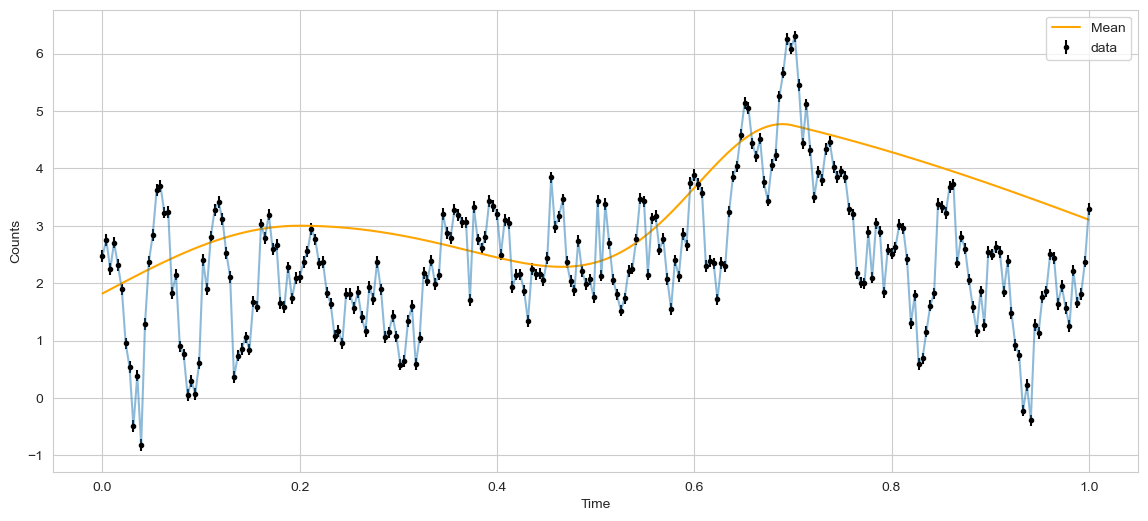

In [3]:
# Sampling out a lightcurve from the GP
counts = gp.sample(key = jax.random.PRNGKey(6))
yerr = (jit)*np.ones_like(times)

fig, ax = plt.subplots(1,1, figsize = (14,6))
ax.errorbar(times, counts.T, yerr=yerr, fmt=".k", capsize=0, label="data")
ax.plot(times, mean(times), color = "orange" ,label = "Mean"); ax.legend()
ax.plot(times, counts, label = "Sample GP", alpha = 0.5)
ax.set_xlabel("Time"); ax.set_ylabel("Counts")

lc = Lightcurve(time = times, counts = counts, dt = times[1]- times[0], skip_checks = True)

## Parameter Posterior Analysis

We will now make our two differing model and then compare the evidences (log evidences $log(p(D|M)) $ ) of fitting the data to the model to check which one fits better.

The main function that we will use will be:

* `gpmodeling.get_gp_params`: This function gives us a list of the parameters of the model based on the kernel and mean type we select.

* `gpmodeling.get_prior_dict`: This function will be can be used to get a suitable generater prior function for a jaxns model. We have to give it our parameter list, and a dictionary with suitable tfpd distributions for the priors. 

* `gpmodeling.get_log_likelihood`: This function will give us a log_likelihood function which calculates the log likelihood probabilty of the data for the given parameter $p(D|\theta, M)$. Here we will have to provide the parameters list, the kernel and mean type of the GP model, as well as the Times and counts of the lightcurve.


### Model 1

The first model which we will make will be a Red-Noise model ,we will use the get_prior and get_likelihood functions to make a suitable prior and log_likelihood function for our Inference. 

The model will have a Red Noise kernel 

$$
k_{rn}(\tau) = a \; exp(-c\tau) $$

where $\tau = |x_i - x_j|$ and the mean function as a gaussian distribution.

In [4]:
import tensorflow_probability.substrates.jax as tfp
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params
tfpd = tfp.distributions
tfpb = tfp.bijectors

params_list = get_gp_params(kernel_type= "RN", mean_type = "gaussian")
print("parameters list", params_list)

parameters list ['log_arn', 'log_crn', 'log_A', 't0', 'log_sig']


We make a parameter list as jaxns requires the parameters in the prior function and log likelihood to be of the same order. Thus if one is using the standard kernel and means then parameter list comes handy, otherwise one can make our own prior and likelihood function.

### Prior and log likelihood

We use Tensorflow_probility to make the parameter priors and put them into the prior_dictionary. The prior types and bounds can be set according to the user discretion. 

**Note** : The priors can be Tfp priors or bijected priors, but we cannot use tfp.joint_distributions in our priors. To make multi-parameter priors or conditioned parameter priors, one can use the priors in `jaxns.special_priors`. 

In [5]:
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "log_A": tfpd.Uniform(low = jnp.log(0.1 * span), high= jnp.log(2 * span)),
    "t0": tfpd.Uniform(low = times[0] - 0.1*total_time, high = times[-1] + 0.1*total_time),
    "log_sig": tfpd.Uniform(low = jnp.log(0.5 * 1 / f), high = jnp.log(2 * total_time)),
    "log_arn": tfpd.Uniform(low = jnp.log(0.1 * span), high = jnp.log(2 * span)),
    "log_crn": tfpd.Uniform(low = jnp.log(1 / total_time), high = jnp.log(f)),
}

params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig"]

prior_model = get_prior(params_list2, prior_dict)

log_likelihood_model = get_log_likelihood(params_list2, kernel_type= "RN", mean_type = "gaussian", times = times, counts = counts)

### Sampling Model 1

We can initialise the GPResult class using a stingray lightcurve, and then perform a Nested Sampling for the given prior_model and likelihood_model.

In [6]:
from stingray.modeling.gpmodeling import GPResult

gpresult = GPResult(lc = lc)
gpresult.sample(prior_model = prior_model, likelihood_model = log_likelihood_model)

INFO[2023-09-28 17:16:32,186]: Sanity check...
INFO[2023-09-28 17:16:32,518]: Sanity check passed


Simulation Complete


We can check the Evidence for the data given the model $Z = p(D|M_1)$, as well see the sampling outcomes for the used parameters.

In [9]:
print("log Evidence: ", gpresult.get_evidence())

log Evidence:  -252.03937847232254


Using the plotting functionality of the GPResult class, we can visualise the posterior distributions of our parameters, look at sampling run summaries and diagnostics.

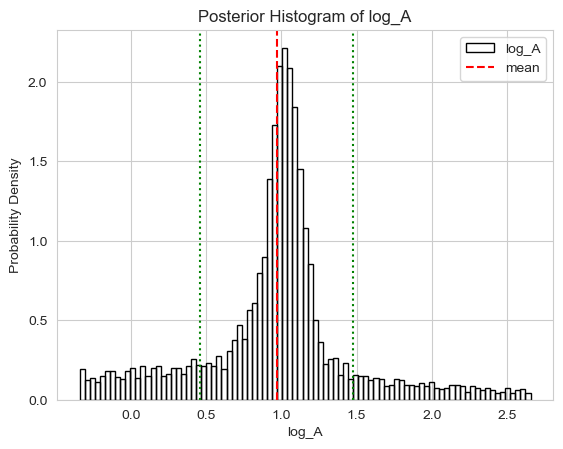

In [10]:
plot = gpresult.posterior_plot("log_A")
plt.show()

In [11]:
gpresult.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 309792
# samples: 7500
# slices: 75000.0
# slices / acceptance: 15.0
# likelihood evals / sample: 41.3
# likelihood evals / slice: 3.9
--------
logZ=-252.04 +- 0.12
H=250.0
ESS=1590
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 0.99 +- 0.15 | 0.82 / 0.99 / 1.16 | 1.13 | 1.13
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 0.39 +- 0.32 | 0.06 / 0.33 / 0.75 | 0.14 | 0.14
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 3.69 +- 0.34 | 3.29 / 3.75 / 4.05 | 3.95 | 3.95
--------
log_sig: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig: -0.15 +- 0.54 | -0.81 / -0.11 / 0.51 | -0.84 | -0.84
--------
t0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
t0: 0.63 +- 0.27 | 0.22 / 0.65 / 0.97 | 0.63 | 0.63
--------


### Model 2

For the second model, we will make a QPO_plus_RN kernel 

$$
k_{qpo+rn}(\tau) = a_{qpo} \; exp(-c_{qpo} \tau) \; cos(2\pi f\tau) + a_{rn} \; exp(-c_{rn} \tau)
$$

We will also use a gaussian mean function with two modes as the mean function.

For this model, we will be making the prior and log_likelihood function on our own instead of using the `get_prior` and `get_likelihood` functions. This will give us more flexibility.

The prior function must be a jaxns compatible prior function. It is quite similar to making the prior_dictionary, just that here, we will wrap each parameters (tfp) prior into the `jaxns.prior` function and use yield to make it a generator function. Then we will return all the parameters in a specific order.

In [18]:
# Prior Function
from jaxns import Prior
from jaxns.special_priors import ForcedIdentifiability
from jaxns.types import float_type

params_list2 = get_gp_params(kernel_type= "QPO_plus_RN", mean_type = "gaussian")
print(params_list2)

total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# Here, we have made mutiple mean function with 2 gaussians.
def prior_model2():
    log_arn = yield Prior(tfpd.Uniform(low = jnp.log(0.1 * span), high = jnp.log(2 * span)), name='log_arn')
    log_crn = yield Prior(tfpd.Uniform(low = jnp.log(1 / total_time), high = jnp.log(f)), name='log_crn')
    log_aqpo = yield Prior(tfpd.Uniform(low = jnp.log(0.1 * span), high = jnp.log(2 * span)), name='log_aqpo')
    log_cqpo = yield Prior(tfpd.Uniform(low = jnp.log(1/10/total_time), high = jnp.log(f)), name='log_cqpo')
    log_freq = yield Prior(tfpd.Uniform(low = jnp.log(2) , high = jnp.log(f/4) ), name='log_freq')

    n = 2
    log_A = yield Prior(tfpd.Uniform(low = jnp.log(0.1 * span)*jnp.ones(n), high = jnp.log(2 * span)*jnp.ones(n)), 
                            name='log_A')
    
    # This is special conditional beta function for the peak times of gaussians which prevents degeneracies
    t0 = []
    scale_bij = tfp.bijectors.Scale(scale = times[-1] - times[0])
    shift_bij = tfp.bijectors.Shift(shift= times[0])
    for i in range(n):
        underlying_beta = tfpd.Beta(
            concentration1=jnp.asarray(1., float_type),
            concentration0=jnp.asarray(n - i, float_type)
        )
        t = yield Prior(shift_bij(scale_bij(underlying_beta)), name=f"t{i}")
        # Updating the shift and scale here
        scale_bij = tfp.bijectors.Scale(scale= times[-1] - t)
        shift_bij = tfp.bijectors.Shift(shift=t)
        t0.append(t)
    t0 = jnp.stack(t0)
    
    log_sig = yield Prior(tfpd.Uniform(low = jnp.log(0.5 * 1 / f) *jnp.ones(n), high = jnp.log(2 * total_time) *jnp.ones(n)), name='log_sig')

    return log_arn, log_crn, log_aqpo, log_cqpo, log_freq, log_A, t0, log_sig


['log_arn', 'log_crn', 'log_aqpo', 'log_cqpo', 'log_freq', 'log_A', 't0', 'log_sig']


For the log_likelihood function, we have to take the paremeters (same order), and return $log(p(D|M)) $ the log probability of fitting the data to the model. This can be done by making the suitable Gaussian process and returning the ` gp.log_probability(lightcurve_counts)`


In [19]:
def log_likelihood_model2( log_arn, log_crn, log_aqpo, log_cqpo, log_freq, log_A, t0, log_sig ):
    
    kernel_params = { "arn": jnp.exp(log_arn), "crn": jnp.exp(log_crn), "aqpo": jnp.exp(log_aqpo), 
                    "cqpo": jnp.exp(log_cqpo), "freq": jnp.exp(log_freq)}
    mean_params = {"A": jnp.exp(log_A), "t0": t0, "sig": jnp.exp(log_sig)}

    kernel = get_kernel(kernel_type="QPO_plus_RN", kernel_params=kernel_params)
    mean = get_mean(mean_type="gaussian", mean_params=mean_params)
    gp = GaussianProcess(kernel, times, mean_value=mean(times))

    return gp.log_probability(counts)

### Sampling Model 2

Similar to the previous case, we will make a GPresult object by initialising with the lightcurve. Then we will sample the posterior using the prior and log_likelihood model.

In [20]:
gpresult2 = GPResult(lc = lc)
gpresult2.sample(prior_model = prior_model2, likelihood_model = log_likelihood_model2, max_samples = 2e4)

INFO[2023-09-05 21:22:28,372]: Sanity check...
INFO[2023-09-05 21:22:28,504]: Sanity check passed


Simulation Complete


This time we get a lower log evidence than the previous model.

In [21]:
print("log Evidence: ", gpresult2.get_evidence())

log Evidence:  -245.70527553934025


## Evidence Comparison

On comapring the evidences of the two model we get the Bayes Factor.

For $M_1$ being QPO_plus_RN model and $M_2$ being the plain RN model.

$$
ln(BF) = ln(Z_1) - ln(Z_2) = -245.70 - (-251.77) = 6.06
$$

As BF is greater than 5.0, this gives us a strong indication that the time series has a Quasi Oscillatory behaviour.

Also, as we can see in the weighted posterior plot for the frequency, We had used a frequency of 20 Hz for our sample and this has been captured very well by the Nested Sampling Inference.

Mean of freq: 19.35595259854821


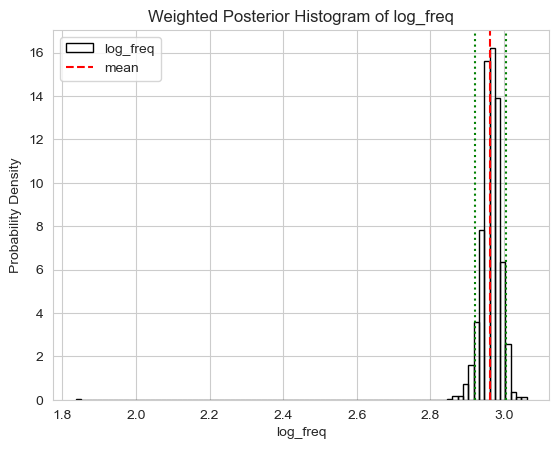

In [23]:
plot = gpresult2.weighted_posterior_plot("log_freq")
print("Mean of freq:", jnp.exp(2.963)) 

For more information on the posterior, we can see a comparison plot between two parameters. (Here the peak times of the gaussian means, which we had conditioned as $t_1>t_0$)

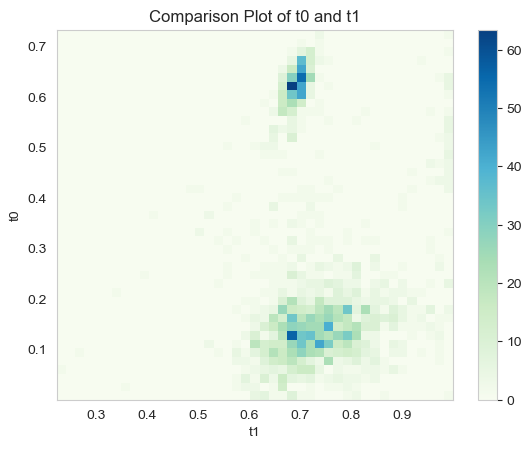

In [25]:
# Corner Plot between the two peak times
plot = gpresult2.comparison_plot("t0", "t1")

In [26]:
gpresult2.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 1611930
# samples: 15152
# slices: 459000.0
# slices / acceptance: 34.0
# likelihood evals / sample: 106.4
# likelihood evals / slice: 3.5
--------
logZ=-245.71 +- 0.17
H=250.0
ESS=1847
--------
log_A[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A[0]: 0.14 +- 0.46 | -0.3 / -0.06 / 0.9 | 0.87 | 0.87
log_A[1]: 0.95 +- 0.24 | 0.69 / 0.99 / 1.18 | 1.11 | 1.11
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 0.73 +- 0.53 | -0.15 / 0.91 / 1.26 | -0.1 | -0.1
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 0.1 +- 0.3 | -0.25 / 0.06 / 0.44 | -0.32 | -0.32
--------
log_cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_cqpo: -1.16 +- 0.87 | -2.08 / -1.43 / 0.22 | 0.38 | 0.38
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) 

## Credits:

1. [Gaussian Process regression for astronomical time-series](https://arxiv.org/pdf/2209.08940.pdf), Suzanne Aigrain, Daniel Foreman-Mackey

2. [Bayesian Model Comparison](https://ned.ipac.caltech.edu/level5/Sept13/Trotta/Trotta4.html), Roberto Trotta

3. [Searching for quasi-periodic oscillations in astrophysical transients using Gaussian processes](https://arxiv.org/abs/2205.12716), Moritz Hubner et al.